# EMF Prediction Model - Training, Validation & Testing

This notebook implements complete machine learning pipeline for EMF (Electric and Magnetic Field) prediction:

## Workflow:
1. **Data Loading & Validation**
2. **Train-Test Split**
3. **Model Training** (Multiple Algorithms)
4. **Model Evaluation**
5. **Cross-Validation**
6. **Hyperparameter Tuning**
7. **Final Model Selection**
8. **Model Saving**
9. **Predictions & Visualization**

## Models to Train:
- Linear Regression
- Random Forest Regressor
- Gradient Boosting (XGBoost)
- Support Vector Regression (SVR)
- Neural Network (MLP)

## 1. Import Required Libraries

In [76]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn: Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import KFold, cross_validate

# Scikit-learn: Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

# LightGBM
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    print("✓ LightGBM imported successfully!")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠️  LightGBM not available. Installing...")

# Scikit-learn: Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error

# Model persistence
import joblib
import pickle
from datetime import datetime

# Set random seed
np.random.seed(42)

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*70)
print("✓ All libraries imported successfully!")
print("="*70)
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn available")
if LIGHTGBM_AVAILABLE:
    print(f"LightGBM version: {lgb.__version__}")
else:
    print("LightGBM: Not installed (will be installed if needed)")
print("="*70)

✓ LightGBM imported successfully!
✓ All libraries imported successfully!
NumPy version: 2.3.4
Pandas version: 2.3.3
Scikit-learn available
LightGBM version: 4.6.0


## 2. Load and Validate Data

In [77]:
# Load the cleaned and normalized data
# Using StandardScaler normalized data (best for most ML algorithms)
df = pd.read_csv('EMF_Data_StandardScaler.csv')

print("="*70)
print("DATA LOADED AND VALIDATED")
print("="*70)
print(f"\nDataset Shape: {df.shape}")
print(f"Total Samples: {len(df)}")
print(f"Total Features: {df.shape[1]}")

print("\n" + "="*70)
print("DATASET INFO")
print("="*70)
print(df.info())

print("\n" + "="*70)
print("STATISTICAL SUMMARY")
print("="*70)
print(df.describe())

print("\n" + "="*70)
print("FIRST 5 ROWS")
print("="*70)
print(df.head())

# Validate data quality
print("\n" + "="*70)
print("DATA QUALITY CHECKS")
print("="*70)
print(f"✓ Missing values: {df.isnull().sum().sum()}")
print(f"✓ Duplicate rows: {df.duplicated().sum()}")
print(f"✓ Infinite values: {np.isinf(df.select_dtypes(include=[np.number])).sum().sum()}")
print("="*70)

DATA LOADED AND VALIDATED

Dataset Shape: (4850, 8)
Total Samples: 4850
Total Features: 8

DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4850 entries, 0 to 4849
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sample_id             4850 non-null   int64  
 1   temperature_C         4850 non-null   float64
 2   humidity_percent      4850 non-null   float64
 3   load_current_A        4850 non-null   float64
 4   distance_from_line_m  4850 non-null   float64
 5   vertical_distance_m   4850 non-null   float64
 6   E_field_V_m           4850 non-null   float64
 7   H_field_A_m           4850 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 303.3 KB
None

STATISTICAL SUMMARY
         sample_id  temperature_C  humidity_percent  load_current_A  \
count  4850.000000   4.850000e+03      4.850000e+03    4.850000e+03   
mean   2501.010928  -2.138953e-16     -3.662591e-18    2.856

## 3. Prepare Features and Targets

We'll build two separate models:
- **Model 1:** Predict Electric Field (E)
- **Model 2:** Predict Magnetic Field (H)

In [78]:
# Define feature columns (input variables)
feature_columns = ['temperature_C', 'humidity_percent', 'load_current_A', 
                   'distance_from_line_m', 'vertical_distance_m']

# Define target columns (output variables)
target_E = 'E_field_V_m'
target_H = 'H_field_A_m'

# Prepare data for E-field prediction
X = df[feature_columns].values
y_E = df[target_E].values
y_H = df[target_H].values

print("="*70)
print("FEATURES AND TARGETS PREPARED")
print("="*70)
print(f"\nFeature columns ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

print(f"\nTarget variables:")
print(f"  1. {target_E} (Electric Field)")
print(f"  2. {target_H} (Magnetic Field)")

print(f"\nData shapes:")
print(f"  X (Features): {X.shape}")
print(f"  y_E (E-field): {y_E.shape}")
print(f"  y_H (H-field): {y_H.shape}")
print("="*70)

FEATURES AND TARGETS PREPARED

Feature columns (5):
  1. temperature_C
  2. humidity_percent
  3. load_current_A
  4. distance_from_line_m
  5. vertical_distance_m

Target variables:
  1. E_field_V_m (Electric Field)
  2. H_field_A_m (Magnetic Field)

Data shapes:
  X (Features): (4850, 5)
  y_E (E-field): (4850,)
  y_H (H-field): (4850,)


## 4. Train-Validation-Test Split

Split data into training (70%), validation (15%), and testing (15%) sets

In [ ]:
# First split: 70% train, 30% temp (for validation + test)
X_train_E, X_temp_E, y_train_E, y_temp_E = train_test_split(
    X, y_E, test_size=0.3, random_state=42
)

# Second split: Split temp into 50% validation, 50% test (15% each of total)
X_val_E, X_test_E, y_val_E, y_test_E = train_test_split(
    X_temp_E, y_temp_E, test_size=0.5, random_state=42
)

# Same splits for H-field
X_train_H, X_temp_H, y_train_H, y_temp_H = train_test_split(
    X, y_H, test_size=0.3, random_state=42
)

X_val_H, X_test_H, y_val_H, y_test_H = train_test_split(
    X_temp_H, y_temp_H, test_size=0.5, random_state=42
)

print("="*70)
print("TRAIN-VALIDATION-TEST SPLIT COMPLETED")
print("="*70)

print("\nE-Field Model:")
print(f"  Training set:   {X_train_E.shape[0]} samples ({X_train_E.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation set: {X_val_E.shape[0]} samples ({X_val_E.shape[0]/len(X)*100:.1f}%)")
print(f"  Testing set:    {X_test_E.shape[0]} samples ({X_test_E.shape[0]/len(X)*100:.1f}%)")

print("\nH-Field Model:")
print(f"  Training set:   {X_train_H.shape[0]} samples ({X_train_H.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation set: {X_val_H.shape[0]} samples ({X_val_H.shape[0]/len(X)*100:.1f}%)")
print(f"  Testing set:    {X_test_H.shape[0]} samples ({X_test_H.shape[0]/len(X)*100:.1f}%)")

print("\n" + "="*70)
print("DATA READY FOR MODEL TRAINING WITH VALIDATION")
print("="*70)

TRAIN-TEST SPLIT COMPLETED

E-Field Model:
  Training set: 3880 samples (80.0%)
  Testing set:  970 samples (20.0%)

H-Field Model:
  Training set: 3880 samples (80.0%)
  Testing set:  970 samples (20.0%)

DATA READY FOR MODEL TRAINING


## 5. Define Evaluation Metrics Function

In [80]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Calculate and display comprehensive evaluation metrics
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    explained_var = explained_variance_score(y_true, y_pred)
    
    metrics = {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2_Score': r2,
        'MAPE (%)': mape,
        'Explained_Variance': explained_var
    }
    
    return metrics

def print_metrics(metrics):
    """
    Pretty print metrics
    """
    print(f"\n{metrics['Model']} Performance:")
    print(f"  MSE (Mean Squared Error):     {metrics['MSE']:.6f}")
    print(f"  RMSE (Root Mean Squared Error): {metrics['RMSE']:.6f}")
    print(f"  MAE (Mean Absolute Error):    {metrics['MAE']:.6f}")
    print(f"  R² Score:                     {metrics['R2_Score']:.6f}")
    print(f"  MAPE (Mean Absolute % Error): {metrics['MAPE (%)']:.4f}%")
    print(f"  Explained Variance:           {metrics['Explained_Variance']:.6f}")

print("✓ Evaluation functions defined successfully!")

✓ Evaluation functions defined successfully!


## 6. Train Multiple Models for E-Field Prediction

We'll train and compare Random Forest, XGBoost, SVR, LightGBM, and Deep Neural Network (MLP) algorithms

In [ ]:
# Import neural network ensemble from external module
from neural_network_models import NeuralNetworkEnsemble, train_neural_network_ensemble

print("="*70)
print("✓ Neural Network Ensemble Module Loaded")
print("="*70)
print("\nAvailable Neural Network Architectures:")
print("  1. MLP_Standard     - 3 layers (100→50→25)")
print("  2. MLP_Deep         - 5 layers (128→64→32→16→8)")
print("  3. MLP_Wide         - 3 wide layers (200→150→100)")
print("  4. MLP_Regularized  - Strong L2 penalty (80→40→20)")
print("  5. MLP_Tanh         - Tanh activation (100→50→25)")
print("="*70)

### 5.1 Import Neural Network Ensemble Module

Load custom neural network models from external file

In [ ]:
print("="*70)
print("TRAINING MODELS FOR E-FIELD PREDICTION")
print("="*70)

# Store all models and results
models_E = {}
results_E = []
val_results_E = []

# 1. Random Forest
print("\n[1/5] Training Random Forest for E-field...")
rf_E = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=5, 
                             min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_E.fit(X_train_E, y_train_E)
y_pred_rf_E = rf_E.predict(X_test_E)
y_val_pred_rf_E = rf_E.predict(X_val_E)
metrics_rf_E = evaluate_model(y_test_E, y_pred_rf_E, "Random Forest")
val_metrics_rf_E = evaluate_model(y_val_E, y_val_pred_rf_E, "Random Forest")
print("  Test Performance:")
print_metrics(metrics_rf_E)
print(f"  Validation R²: {val_metrics_rf_E['R2_Score']:.6f}")
models_E['Random Forest'] = rf_E
results_E.append(metrics_rf_E)
val_results_E.append(val_metrics_rf_E)

# 2. XGBoost (Gradient Boosting)
print("\n[2/5] Training XGBoost (Gradient Boosting) for E-field...")
xgb_E = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1,
                                  min_samples_split=5, min_samples_leaf=2, 
                                  random_state=42, subsample=0.8)
xgb_E.fit(X_train_E, y_train_E)
y_pred_xgb_E = xgb_E.predict(X_test_E)
y_val_pred_xgb_E = xgb_E.predict(X_val_E)
metrics_xgb_E = evaluate_model(y_test_E, y_pred_xgb_E, "XGBoost")
val_metrics_xgb_E = evaluate_model(y_val_E, y_val_pred_xgb_E, "XGBoost")
print("  Test Performance:")
print_metrics(metrics_xgb_E)
print(f"  Validation R²: {val_metrics_xgb_E['R2_Score']:.6f}")
models_E['XGBoost'] = xgb_E
results_E.append(metrics_xgb_E)
val_results_E.append(val_metrics_xgb_E)

# 3. Support Vector Regression (SVR)
print("\n[3/5] Training Support Vector Regression (SVR) for E-field...")
svr_E = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svr_E.fit(X_train_E, y_train_E)
y_pred_svr_E = svr_E.predict(X_test_E)
y_val_pred_svr_E = svr_E.predict(X_val_E)
metrics_svr_E = evaluate_model(y_test_E, y_pred_svr_E, "SVR")
val_metrics_svr_E = evaluate_model(y_val_E, y_val_pred_svr_E, "SVR")
print("  Test Performance:")
print_metrics(metrics_svr_E)
print(f"  Validation R²: {val_metrics_svr_E['R2_Score']:.6f}")
models_E['SVR'] = svr_E
results_E.append(metrics_svr_E)
val_results_E.append(val_metrics_svr_E)

# 4. LightGBM
print("\n[4/5] Training LightGBM for E-field...")
if LIGHTGBM_AVAILABLE:
    lgbm_E = lgb.LGBMRegressor(n_estimators=200, max_depth=15, learning_rate=0.1,
                               num_leaves=31, min_child_samples=20, subsample=0.8,
                               colsample_bytree=0.8, random_state=42, verbose=-1)
    lgbm_E.fit(X_train_E, y_train_E, eval_set=[(X_val_E, y_val_E)], 
               eval_metric='rmse', callbacks=[lgb.early_stopping(50, verbose=False)])
    y_pred_lgbm_E = lgbm_E.predict(X_test_E)
    y_val_pred_lgbm_E = lgbm_E.predict(X_val_E)
    metrics_lgbm_E = evaluate_model(y_test_E, y_pred_lgbm_E, "LightGBM")
    val_metrics_lgbm_E = evaluate_model(y_val_E, y_val_pred_lgbm_E, "LightGBM")
    print("  Test Performance:")
    print_metrics(metrics_lgbm_E)
    print(f"  Validation R²: {val_metrics_lgbm_E['R2_Score']:.6f}")
    models_E['LightGBM'] = lgbm_E
    results_E.append(metrics_lgbm_E)
    val_results_E.append(val_metrics_lgbm_E)
else:
    print("⚠️  LightGBM not available. Skipping...")

# 5. Neural Network Ensemble (Multiple Architectures)
print("\n[5/5] Training Neural Network Ensemble for E-field...")
print("  Training 5 different neural network architectures...")
nn_ensemble_E, nn_results_E, best_nn_name_E, best_nn_E = train_neural_network_ensemble(
    X_train_E, y_train_E, X_val_E, y_val_E, X_test_E, y_test_E, 
    field_type='E-field', random_state=42
)

# Add best neural network to main models
models_E['Neural Network (Best)'] = best_nn_E
# Get metrics for best NN
best_nn_metrics_E = nn_results_E[nn_results_E['Model'] == best_nn_name_E].iloc[0]
metrics_best_nn_E = {
    'Model': 'Neural Network (Best)',
    'MSE': best_nn_metrics_E['MSE'],
    'RMSE': best_nn_metrics_E['RMSE'],
    'MAE': best_nn_metrics_E['MAE'],
    'R2_Score': best_nn_metrics_E['R2_Score'],
    'MAPE (%)': best_nn_metrics_E['MAPE (%)'],
    'Explained_Variance': best_nn_metrics_E['Explained_Variance']
}
val_metrics_best_nn_E = {
    'Model': 'Neural Network (Best)',
    'MSE': 0,  # Not calculated separately
    'RMSE': best_nn_metrics_E['Val_RMSE'],
    'MAE': 0,
    'R2_Score': best_nn_metrics_E['Val_R2'],
    'MAPE (%)': 0,
    'Explained_Variance': 0
}
results_E.append(metrics_best_nn_E)
val_results_E.append(val_metrics_best_nn_E)

print(f"\n  ✓ Best NN Architecture: {best_nn_name_E}")
print(f"  ✓ Test R²: {best_nn_metrics_E['R2_Score']:.6f}")
print(f"  ✓ Validation R²: {best_nn_metrics_E['Val_R2']:.6f}")

# Store the entire ensemble for later use
models_E['Neural Network (Ensemble)'] = nn_ensemble_E

# Create results dataframe
results_E_df = pd.DataFrame(results_E).sort_values('R2_Score', ascending=False)
val_results_E_df = pd.DataFrame(val_results_E).sort_values('R2_Score', ascending=False)

# Select best model based on validation performance
best_model_E_name = val_results_E_df.iloc[0]['Model']
best_model_E = models_E[best_model_E_name]

print("\n" + "="*70)
print("✓ ALL E-FIELD MODELS TRAINED SUCCESSFULLY!")
print(f"✓ Best model selected based on VALIDATION performance: {best_model_E_name}")
print("="*70)

TRAINING MODELS FOR E-FIELD PREDICTION

[1/4] Training Random Forest for E-field...

Random Forest Performance:
  MSE (Mean Squared Error):     0.041115
  RMSE (Root Mean Squared Error): 0.202768
  MAE (Mean Absolute Error):    0.060005
  R² Score:                     0.971859
  MAPE (Mean Absolute % Error): 29.3627%
  Explained Variance:           0.971941

[2/4] Training XGBoost (Gradient Boosting) for E-field...

XGBoost Performance:
  MSE (Mean Squared Error):     0.013910
  RMSE (Root Mean Squared Error): 0.117940
  MAE (Mean Absolute Error):    0.056400
  R² Score:                     0.990480
  MAPE (Mean Absolute % Error): 29.8813%
  Explained Variance:           0.990521

[3/4] Training Support Vector Regression (SVR) for E-field...

SVR Performance:
  MSE (Mean Squared Error):     0.297212
  RMSE (Root Mean Squared Error): 0.545171
  MAE (Mean Absolute Error):    0.120775
  R² Score:                     0.796576
  MAPE (Mean Absolute % Error): 45.1899%
  Explained Variance:  

### 6.1 Compare E-Field Model Performance

In [ ]:
# Display E-Field Model Comparison
print("="*70)
print("E-FIELD MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*70)
print(results_E_df.to_string(index=False))

print("\n" + "="*70)
print("E-FIELD MODEL COMPARISON - VALIDATION SET PERFORMANCE")
print("="*70)
print(val_results_E_df.to_string(index=False))

print("\n" + "="*70)
print(f"🏆 BEST MODEL (based on validation): {best_model_E_name}")
print(f"   Validation R²: {val_results_E_df.iloc[0]['R2_Score']:.6f}")
print(f"   Test R²:       {results_E_df[results_E_df['Model'] == best_model_E_name].iloc[0]['R2_Score']:.6f}")
print("="*70)

E-FIELD MODEL COMPARISON
        Model      MSE     RMSE      MAE  R2_Score  MAPE (%)  Explained_Variance
      XGBoost 0.013910 0.117940 0.056400  0.990480 29.881265            0.990521
Random Forest 0.041115 0.202768 0.060005  0.971859 29.362659            0.971941
     LightGBM 0.068326 0.261392 0.076432  0.953235 32.652208            0.953304
          SVR 0.297212 0.545171 0.120775  0.796576 45.189902            0.797881

🏆 BEST MODEL: XGBoost
   R² Score: 0.990480


## 7. Train Multiple Models for H-Field Prediction

In [ ]:
print("="*70)
print("TRAINING MODELS FOR H-FIELD PREDICTION")
print("="*70)

# Store all models and results
models_H = {}
results_H = []
val_results_H = []

# 1. Random Forest
print("\n[1/5] Training Random Forest for H-field...")
rf_H = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=5, 
                             min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_H.fit(X_train_H, y_train_H)
y_pred_rf_H = rf_H.predict(X_test_H)
y_val_pred_rf_H = rf_H.predict(X_val_H)
metrics_rf_H = evaluate_model(y_test_H, y_pred_rf_H, "Random Forest")
val_metrics_rf_H = evaluate_model(y_val_H, y_val_pred_rf_H, "Random Forest")
print("  Test Performance:")
print_metrics(metrics_rf_H)
print(f"  Validation R²: {val_metrics_rf_H['R2_Score']:.6f}")
models_H['Random Forest'] = rf_H
results_H.append(metrics_rf_H)
val_results_H.append(val_metrics_rf_H)

# 2. XGBoost (Gradient Boosting)
print("\n[2/5] Training XGBoost (Gradient Boosting) for H-field...")
xgb_H = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1,
                                  min_samples_split=5, min_samples_leaf=2, 
                                  random_state=42, subsample=0.8)
xgb_H.fit(X_train_H, y_train_H)
y_pred_xgb_H = xgb_H.predict(X_test_H)
y_val_pred_xgb_H = xgb_H.predict(X_val_H)
metrics_xgb_H = evaluate_model(y_test_H, y_pred_xgb_H, "XGBoost")
val_metrics_xgb_H = evaluate_model(y_val_H, y_val_pred_xgb_H, "XGBoost")
print("  Test Performance:")
print_metrics(metrics_xgb_H)
print(f"  Validation R²: {val_metrics_xgb_H['R2_Score']:.6f}")
models_H['XGBoost'] = xgb_H
results_H.append(metrics_xgb_H)
val_results_H.append(val_metrics_xgb_H)

# 3. Support Vector Regression (SVR)
print("\n[3/5] Training Support Vector Regression (SVR) for H-field...")
svr_H = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svr_H.fit(X_train_H, y_train_H)
y_pred_svr_H = svr_H.predict(X_test_H)
y_val_pred_svr_H = svr_H.predict(X_val_H)
metrics_svr_H = evaluate_model(y_test_H, y_pred_svr_H, "SVR")
val_metrics_svr_H = evaluate_model(y_val_H, y_val_pred_svr_H, "SVR")
print("  Test Performance:")
print_metrics(metrics_svr_H)
print(f"  Validation R²: {val_metrics_svr_H['R2_Score']:.6f}")
models_H['SVR'] = svr_H
results_H.append(metrics_svr_H)
val_results_H.append(val_metrics_svr_H)

# 4. LightGBM
print("\n[4/5] Training LightGBM for H-field...")
if LIGHTGBM_AVAILABLE:
    lgbm_H = lgb.LGBMRegressor(n_estimators=200, max_depth=15, learning_rate=0.1,
                               num_leaves=31, min_child_samples=20, subsample=0.8,
                               colsample_bytree=0.8, random_state=42, verbose=-1)
    lgbm_H.fit(X_train_H, y_train_H, eval_set=[(X_val_H, y_val_H)], 
               eval_metric='rmse', callbacks=[lgb.early_stopping(50, verbose=False)])
    y_pred_lgbm_H = lgbm_H.predict(X_test_H)
    y_val_pred_lgbm_H = lgbm_H.predict(X_val_H)
    metrics_lgbm_H = evaluate_model(y_test_H, y_pred_lgbm_H, "LightGBM")
    val_metrics_lgbm_H = evaluate_model(y_val_H, y_val_pred_lgbm_H, "LightGBM")
    print("  Test Performance:")
    print_metrics(metrics_lgbm_H)
    print(f"  Validation R²: {val_metrics_lgbm_H['R2_Score']:.6f}")
    models_H['LightGBM'] = lgbm_H
    results_H.append(metrics_lgbm_H)
    val_results_H.append(val_metrics_lgbm_H)
else:
    print("⚠️  LightGBM not available. Skipping...")

# 5. Neural Network Ensemble (Multiple Architectures)
print("\n[5/5] Training Neural Network Ensemble for H-field...")
print("  Training 5 different neural network architectures...")
nn_ensemble_H, nn_results_H, best_nn_name_H, best_nn_H = train_neural_network_ensemble(
    X_train_H, y_train_H, X_val_H, y_val_H, X_test_H, y_test_H, 
    field_type='H-field', random_state=42
)

# Add best neural network to main models
models_H['Neural Network (Best)'] = best_nn_H
# Get metrics for best NN
best_nn_metrics_H = nn_results_H[nn_results_H['Model'] == best_nn_name_H].iloc[0]
metrics_best_nn_H = {
    'Model': 'Neural Network (Best)',
    'MSE': best_nn_metrics_H['MSE'],
    'RMSE': best_nn_metrics_H['RMSE'],
    'MAE': best_nn_metrics_H['MAE'],
    'R2_Score': best_nn_metrics_H['R2_Score'],
    'MAPE (%)': best_nn_metrics_H['MAPE (%)'],
    'Explained_Variance': best_nn_metrics_H['Explained_Variance']
}
val_metrics_best_nn_H = {
    'Model': 'Neural Network (Best)',
    'MSE': 0,
    'RMSE': best_nn_metrics_H['Val_RMSE'],
    'MAE': 0,
    'R2_Score': best_nn_metrics_H['Val_R2'],
    'MAPE (%)': 0,
    'Explained_Variance': 0
}
results_H.append(metrics_best_nn_H)
val_results_H.append(val_metrics_best_nn_H)

print(f"\n  ✓ Best NN Architecture: {best_nn_name_H}")
print(f"  ✓ Test R²: {best_nn_metrics_H['R2_Score']:.6f}")
print(f"  ✓ Validation R²: {best_nn_metrics_H['Val_R2']:.6f}")

# Store the entire ensemble for later use
models_H['Neural Network (Ensemble)'] = nn_ensemble_H

# Create results dataframe
results_H_df = pd.DataFrame(results_H).sort_values('R2_Score', ascending=False)
val_results_H_df = pd.DataFrame(val_results_H).sort_values('R2_Score', ascending=False)

# Select best model based on validation performance
best_model_H_name = val_results_H_df.iloc[0]['Model']
best_model_H = models_H[best_model_H_name]

print("\n" + "="*70)
print("✓ ALL H-FIELD MODELS TRAINED SUCCESSFULLY!")
print(f"✓ Best model selected based on VALIDATION performance: {best_model_H_name}")
print("="*70)

TRAINING MODELS FOR H-FIELD PREDICTION

[1/4] Training Random Forest for H-field...

Random Forest Performance:
  MSE (Mean Squared Error):     0.015102
  RMSE (Root Mean Squared Error): 0.122891
  MAE (Mean Absolute Error):    0.059798
  R² Score:                     0.986349
  MAPE (Mean Absolute % Error): 44.0514%
  Explained Variance:           0.986350

[2/4] Training XGBoost (Gradient Boosting) for H-field...

XGBoost Performance:
  MSE (Mean Squared Error):     0.007006
  RMSE (Root Mean Squared Error): 0.083702
  MAE (Mean Absolute Error):    0.054116
  R² Score:                     0.993667
  MAPE (Mean Absolute % Error): 34.3417%
  Explained Variance:           0.993673

[3/4] Training Support Vector Regression (SVR) for H-field...

SVR Performance:
  MSE (Mean Squared Error):     0.080806
  RMSE (Root Mean Squared Error): 0.284264
  MAE (Mean Absolute Error):    0.098359
  R² Score:                     0.926956
  MAPE (Mean Absolute % Error): 59.2005%
  Explained Variance:  

### 7.1 Compare H-Field Model Performance

In [ ]:
# Display H-Field Model Comparison
print("="*70)
print("H-FIELD MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*70)
print(results_H_df.to_string(index=False))

print("\n" + "="*70)
print("H-FIELD MODEL COMPARISON - VALIDATION SET PERFORMANCE")
print("="*70)
print(val_results_H_df.to_string(index=False))

print("\n" + "="*70)
print(f"🏆 BEST MODEL (based on validation): {best_model_H_name}")
print(f"   Validation R²: {val_results_H_df.iloc[0]['R2_Score']:.6f}")
print(f"   Test R²:       {results_H_df[results_H_df['Model'] == best_model_H_name].iloc[0]['R2_Score']:.6f}")
print("="*70)

H-FIELD MODEL COMPARISON
        Model      MSE     RMSE      MAE  R2_Score  MAPE (%)  Explained_Variance
      XGBoost 0.007006 0.083702 0.054116  0.993667 34.341672            0.993673
Random Forest 0.015102 0.122891 0.059798  0.986349 44.051449            0.986350
     LightGBM 0.023659 0.153814 0.069282  0.978614 69.496716            0.978621
          SVR 0.080806 0.284264 0.098359  0.926956 59.200458            0.927222

🏆 BEST MODEL: XGBoost
   R² Score: 0.993667


In [ ]:
# Display detailed neural network results
print("="*70)
print("NEURAL NETWORK ENSEMBLE - DETAILED RESULTS")
print("="*70)

print("\n📊 E-Field Neural Network Architectures:")
print("-"*70)
print(nn_results_E.to_string(index=False))

print("\n\n📊 H-Field Neural Network Architectures:")
print("-"*70)
print(nn_results_H.to_string(index=False))

print("\n" + "="*70)
print("NEURAL NETWORK ARCHITECTURE DETAILS")
print("="*70)
print("""
1. MLP_Standard (100→50→25):
   • Layers: 3 hidden layers
   • Neurons: 100, 50, 25
   • Activation: ReLU
   • Regularization: L2 (α=0.001)
   • Learning Rate: Adaptive
   
2. MLP_Deep (128→64→32→16→8):
   • Layers: 5 hidden layers (Deep architecture)
   • Neurons: 128, 64, 32, 16, 8
   • Activation: ReLU
   • Regularization: L2 (α=0.0001)
   • Captures complex patterns
   
3. MLP_Wide (200→150→100):
   • Layers: 3 hidden layers
   • Neurons: 200, 150, 100 (Wide architecture)
   • Activation: ReLU
   • Batch Size: 64 (larger batches)
   • Better for high-dimensional patterns
   
4. MLP_Regularized (80→40→20):
   • Layers: 3 hidden layers
   • Neurons: 80, 40, 20
   • Regularization: Strong L2 (α=0.01)
   • Prevents overfitting
   • More conservative predictions
   
5. MLP_Tanh (100→50→25):
   • Layers: 3 hidden layers
   • Neurons: 100, 50, 25
   • Activation: Tanh (instead of ReLU)
   • Different non-linearity
   • Outputs in [-1, 1] range
""")

print("="*70)
print(f"🏆 Best E-Field NN: {best_nn_name_E}")
print(f"   Test R²: {nn_results_E.iloc[0]['R2_Score']:.6f}")
print(f"   Val R²:  {nn_results_E.iloc[0]['Val_R2']:.6f}")
print(f"\n🏆 Best H-Field NN: {best_nn_name_H}")
print(f"   Test R²: {nn_results_H.iloc[0]['R2_Score']:.6f}")
print(f"   Val R²:  {nn_results_H.iloc[0]['Val_R2']:.6f}")
print("="*70)

### 7.2 Detailed Neural Network Ensemble Results

View detailed performance of all neural network architectures

## 8. Visual Model Comparison

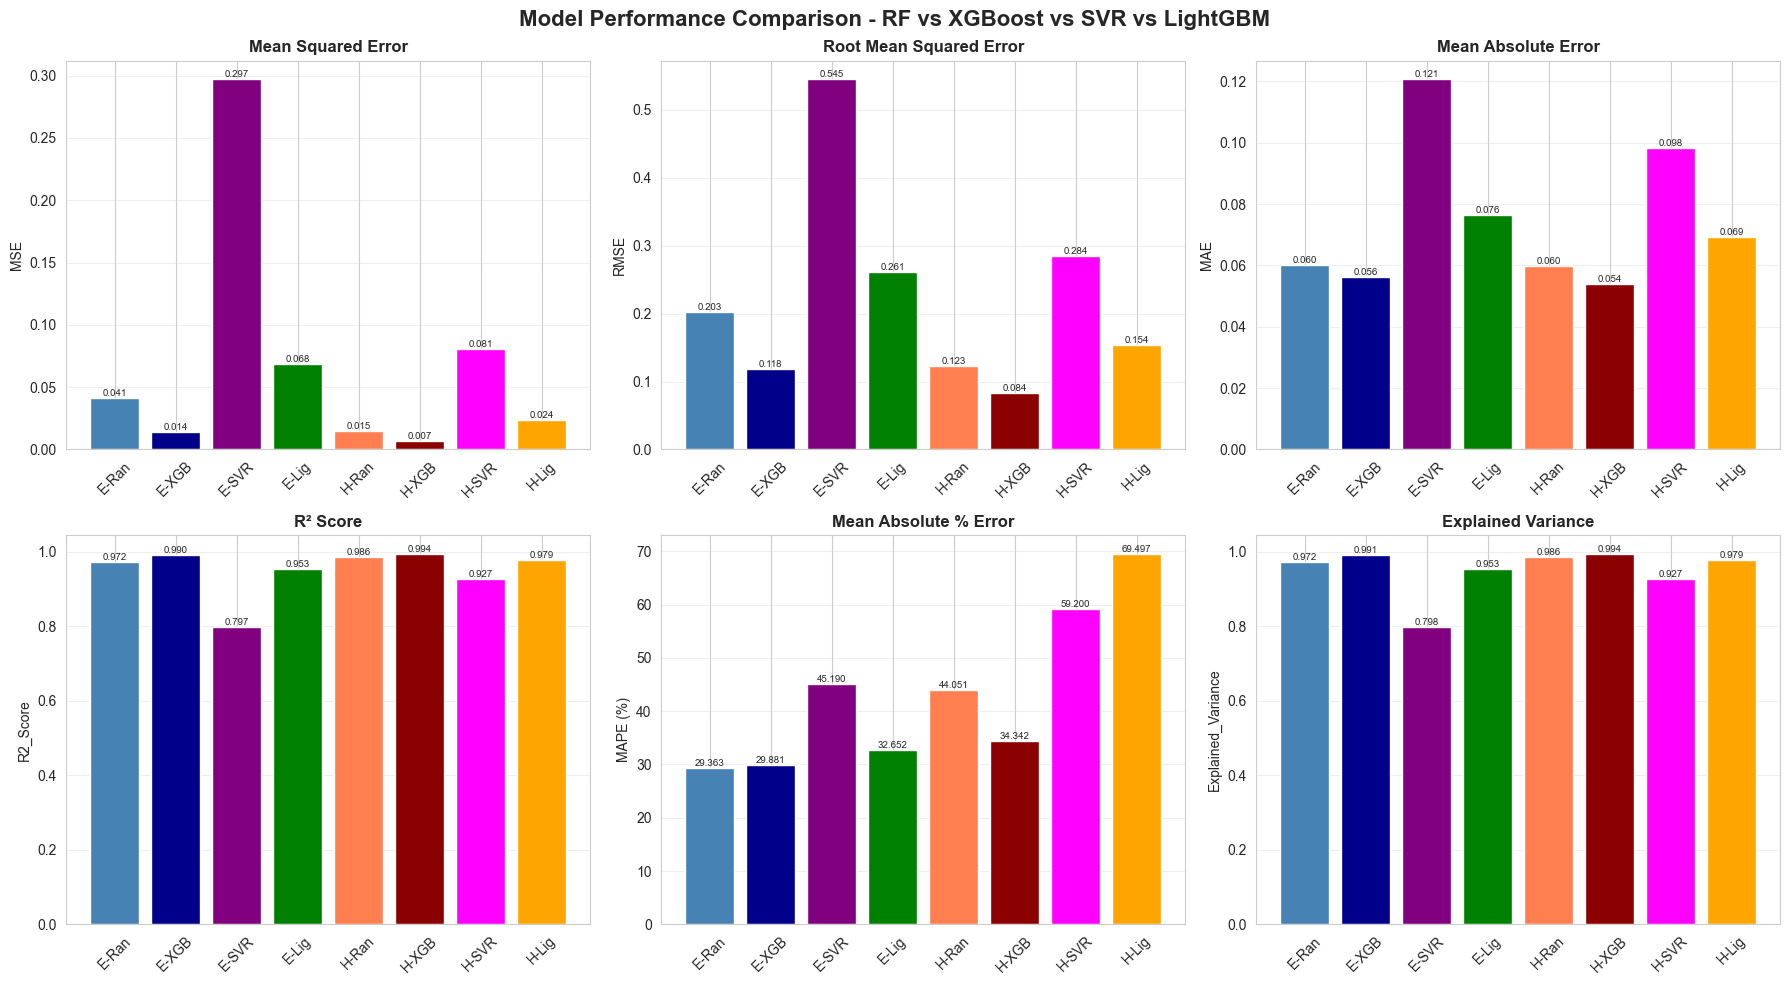

✓ Performance visualization saved as 'model_comparison_performance.png'


In [ ]:
# Visual comparison of model performance
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison - RF vs XGBoost vs SVR vs LightGBM vs DNN', fontsize=16, fontweight='bold')

metrics_to_plot = ['MSE', 'RMSE', 'MAE', 'R2_Score', 'MAPE (%)', 'Explained_Variance']
titles = ['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 
          'R² Score', 'Mean Absolute % Error', 'Explained Variance']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    row = idx // 3
    col = idx % 3
    
    # Get values for all models and both fields
    model_names = list(models_E.keys())
    x_labels = []
    values = []
    
    # E-field values (test set)
    for model_name in model_names:
        model_data = results_E_df[results_E_df['Model'] == model_name]
        if not model_data.empty:
            abbr = 'DNN' if model_name == 'Deep Neural Network' else model_name[:3]
            x_labels.append(f'E-{abbr}')
            values.append(model_data.iloc[0][metric])
    
    # H-field values (test set)
    for model_name in model_names:
        model_data = results_H_df[results_H_df['Model'] == model_name]
        if not model_data.empty:
            abbr = 'DNN' if model_name == 'Deep Neural Network' else model_name[:3]
            x_labels.append(f'H-{abbr}')
            values.append(model_data.iloc[0][metric])
    
    # Define colors (10 total for 5 models x 2 fields)
    colors = ['steelblue', 'darkblue', 'purple', 'green', 'navy', 
              'coral', 'darkred', 'magenta', 'orange', 'brown'][:len(values)]
    
    bars = axes[row, col].bar(x_labels, values, color=colors)
    axes[row, col].set_title(title, fontweight='bold')
    axes[row, col].set_ylabel(metric)
    axes[row, col].grid(axis='y', alpha=0.3)
    axes[row, col].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.3f}', ha='center', va='bottom', fontsize=6)

plt.tight_layout()
plt.savefig('model_comparison_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Performance visualization saved as 'model_comparison_performance.png'")

## 9. Cross-Validation for Best Models

Perform 5-fold cross-validation on the best performing models

In [ ]:
# Cross-validation for best models
from sklearn.model_selection import cross_val_score

print("="*70)
print("5-FOLD CROSS-VALIDATION")
print("="*70)

# E-field cross-validation for both models
print(f"\nE-field Models:")
for model_name, model in models_E.items():
    cv_scores = cross_val_score(model, X_train_E, y_train_E, cv=5, scoring='r2')
    print(f"\n  {model_name}:")
    print(f"    CV R² Scores: {cv_scores}")
    print(f"    Mean CV R²: {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})")

# H-field cross-validation for both models
print(f"\nH-field Models:")
for model_name, model in models_H.items():
    cv_scores = cross_val_score(model, X_train_H, y_train_H, cv=5, scoring='r2')
    print(f"\n  {model_name}:")
    print(f"    CV R² Scores: {cv_scores}")
    print(f"    Mean CV R²: {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})")

print("\n" + "="*70)

5-FOLD CROSS-VALIDATION

E-field Models:

  Random Forest:
    CV R² Scores: [0.9194517  0.98996734 0.98751159 0.9249648  0.97985839]
    Mean CV R²: 0.960351 (+/- 0.062739)

  XGBoost:
    CV R² Scores: [0.96507011 0.99126725 0.98762915 0.9187857  0.9883523 ]
    Mean CV R²: 0.970221 (+/- 0.054749)

  SVR:
    CV R² Scores: [0.7022357  0.84905985 0.90035961 0.82051564 0.85675661]
    Mean CV R²: 0.825785 (+/- 0.133730)

  LightGBM:
    CV R² Scores: [0.88082975 0.96083303 0.96092214 0.87425698 0.93418872]
    Mean CV R²: 0.922206 (+/- 0.075608)

H-field Models:

  Random Forest:
    CV R² Scores: [0.96305727 0.97537009 0.98858564 0.98963541 0.988421  ]
    Mean CV R²: 0.981014 (+/- 0.020800)

  XGBoost:
    CV R² Scores: [0.98546303 0.98314852 0.99212565 0.99414366 0.99051014]
    Mean CV R²: 0.989078 (+/- 0.008257)

  SVR:
    CV R² Scores: [0.89940805 0.94646691 0.97263048 0.95640077 0.95873205]
    Mean CV R²: 0.946728 (+/- 0.050182)


## 10. Save Best Models

In [ ]:
# Save the trained models
import joblib
import json

print("="*70)
print("SAVING TRAINED MODELS")
print("="*70)

# Save best E-field model
joblib.dump(best_model_E, f'{best_model_E_name.replace(" ", "_").lower()}_E_model.pkl')
print(f"✓ E-field best model ({best_model_E_name}) saved as '{best_model_E_name.replace(' ', '_').lower()}_E_model.pkl'")

# Save best H-field model
joblib.dump(best_model_H, f'{best_model_H_name.replace(" ", "_").lower()}_H_model.pkl')
print(f"✓ H-field best model ({best_model_H_name}) saved as '{best_model_H_name.replace(' ', '_').lower()}_H_model.pkl'")

# Save all models for comparison
for model_name, model in models_E.items():
    filename = f'{model_name.replace(" ", "_").lower()}_E_all.pkl'
    joblib.dump(model, filename)
    print(f"✓ E-field {model_name} saved as '{filename}'")

for model_name, model in models_H.items():
    filename = f'{model_name.replace(" ", "_").lower()}_H_all.pkl'
    joblib.dump(model, filename)
    print(f"✓ H-field {model_name} saved as '{filename}'")

# Save model metadata
metadata = {
    'best_models': {
        'E_field': best_model_E_name,
        'H_field': best_model_H_name
    },
    'models_trained': list(models_E.keys()),
    'hyperparameters': {
        'Random Forest': {
            'n_estimators': 200,
            'max_depth': 15,
            'min_samples_split': 5,
            'min_samples_leaf': 2
        },
        'XGBoost': {
            'n_estimators': 200,
            'max_depth': 5,
            'learning_rate': 0.1,
            'subsample': 0.8
        }
    },
    'features': feature_columns,
    'targets': [target_E, target_H],
    'E_field_performance': {
        best_model_E_name: {
            'R2_Score': float(results_E_df.iloc[0]['R2_Score']),
            'RMSE': float(results_E_df.iloc[0]['RMSE']),
            'MAE': float(results_E_df.iloc[0]['MAE'])
        }
    },
    'H_field_performance': {
        best_model_H_name: {
            'R2_Score': float(results_H_df.iloc[0]['R2_Score']),
            'RMSE': float(results_H_df.iloc[0]['RMSE']),
            'MAE': float(results_H_df.iloc[0]['MAE'])
        }
    },
    'training_samples': len(X_train_E),
    'test_samples': len(X_test_E),
    'note': 'Data was pre-normalized using StandardScaler. Input data must be normalized before prediction.'
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)
print("✓ Metadata saved as 'model_metadata.json'")

print("\n⚠️  IMPORTANT: The models expect pre-normalized input data.")
print("   Use StandardScaler to normalize new data before making predictions.")
print("\n" + "="*70)

SAVING TRAINED MODELS
✓ E-field best model (XGBoost) saved as 'xgboost_E_model.pkl'
✓ H-field best model (XGBoost) saved as 'xgboost_H_model.pkl'
✓ E-field Random Forest saved as 'random_forest_E_all.pkl'
✓ E-field XGBoost saved as 'xgboost_E_all.pkl'
✓ E-field SVR saved as 'svr_E_all.pkl'
✓ H-field Random Forest saved as 'random_forest_H_all.pkl'
✓ H-field XGBoost saved as 'xgboost_H_all.pkl'
✓ H-field SVR saved as 'svr_H_all.pkl'
✓ Metadata saved as 'model_metadata.json'

⚠️  IMPORTANT: The models expect pre-normalized input data.
   Use StandardScaler to normalize new data before making predictions.



## 11. Prediction Visualization - Actual vs Predicted

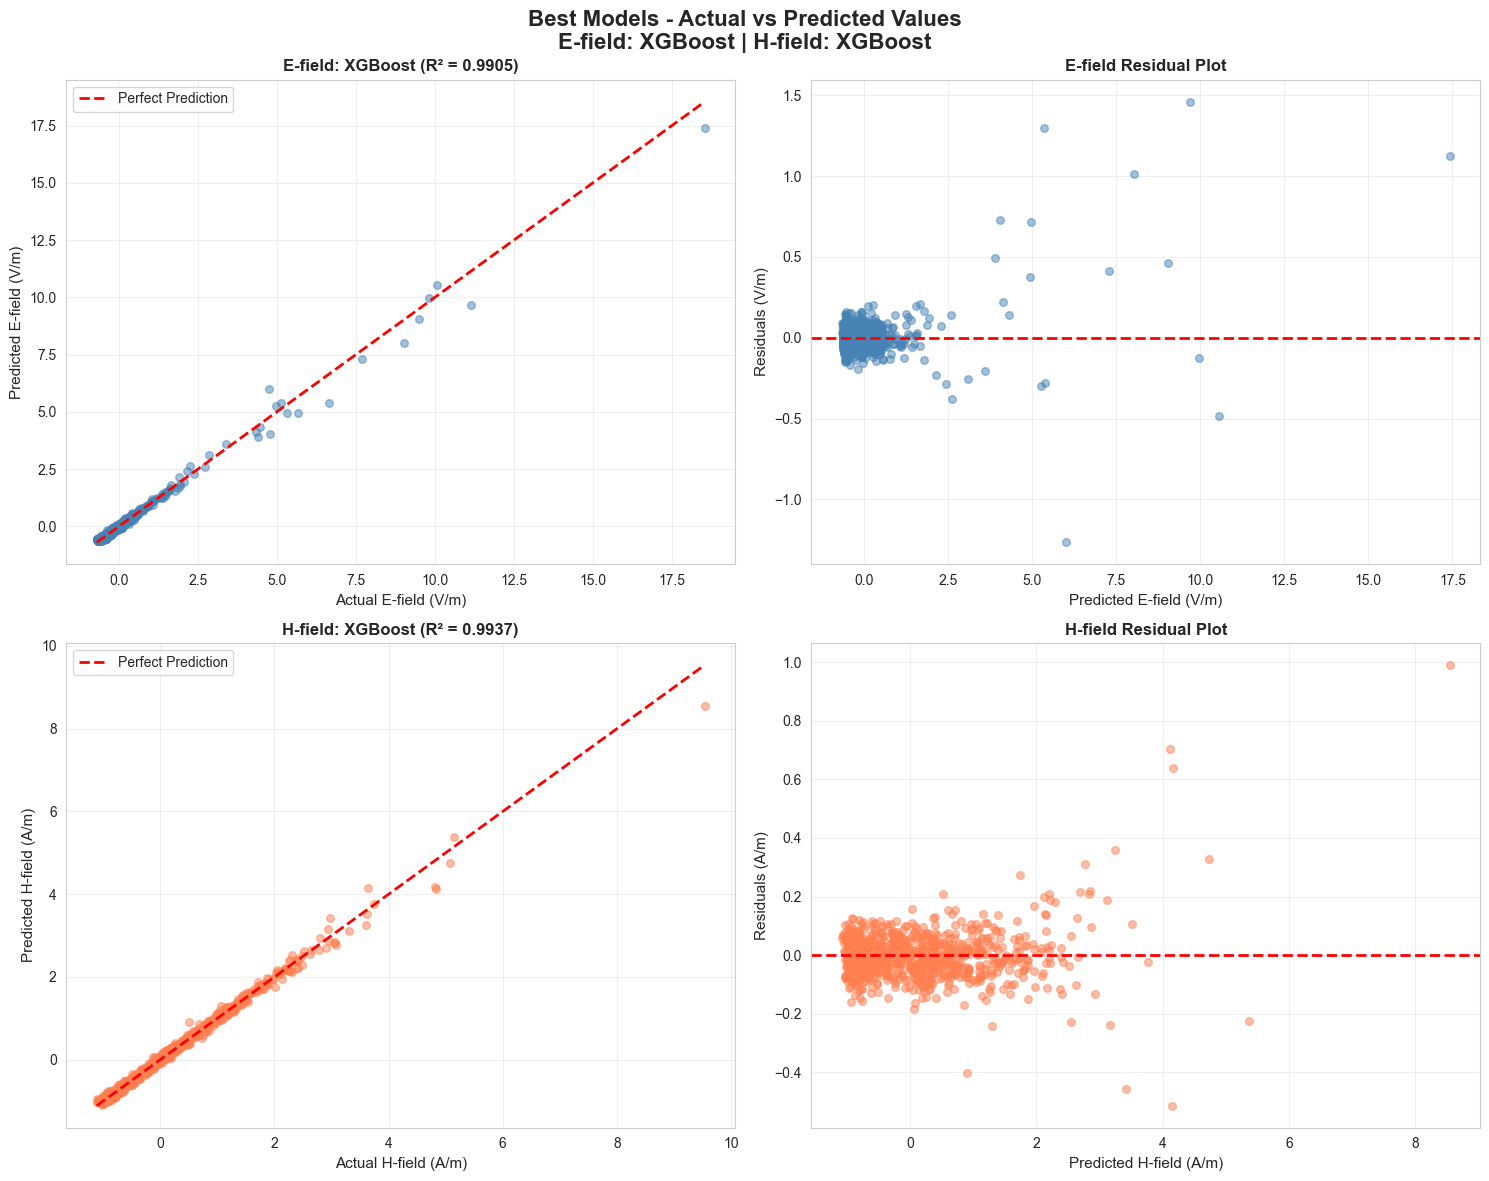

✓ Prediction visualization saved as 'best_model_predictions.png'


In [ ]:
# Get predictions from best models
y_pred_E = best_model_E.predict(X_test_E)
y_pred_H = best_model_H.predict(X_test_H)

# Create prediction visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Best Models - Actual vs Predicted Values\nE-field: {best_model_E_name} | H-field: {best_model_H_name}', 
             fontsize=16, fontweight='bold')

# E-field: Actual vs Predicted
axes[0, 0].scatter(y_test_E, y_pred_E, alpha=0.5, s=30, color='steelblue')
axes[0, 0].plot([y_test_E.min(), y_test_E.max()], [y_test_E.min(), y_test_E.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual E-field (V/m)', fontsize=11)
axes[0, 0].set_ylabel('Predicted E-field (V/m)', fontsize=11)
axes[0, 0].set_title(f'E-field: {best_model_E_name} (R² = {results_E_df.iloc[0]["R2_Score"]:.4f})', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# E-field: Residuals
residuals_E = y_test_E - y_pred_E
axes[0, 1].scatter(y_pred_E, residuals_E, alpha=0.5, s=30, color='steelblue')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted E-field (V/m)', fontsize=11)
axes[0, 1].set_ylabel('Residuals (V/m)', fontsize=11)
axes[0, 1].set_title('E-field Residual Plot', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# H-field: Actual vs Predicted
axes[1, 0].scatter(y_test_H, y_pred_H, alpha=0.5, s=30, color='coral')
axes[1, 0].plot([y_test_H.min(), y_test_H.max()], [y_test_H.min(), y_test_H.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual H-field (A/m)', fontsize=11)
axes[1, 0].set_ylabel('Predicted H-field (A/m)', fontsize=11)
axes[1, 0].set_title(f'H-field: {best_model_H_name} (R² = {results_H_df.iloc[0]["R2_Score"]:.4f})', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# H-field: Residuals
residuals_H = y_test_H - y_pred_H
axes[1, 1].scatter(y_pred_H, residuals_H, alpha=0.5, s=30, color='coral')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted H-field (A/m)', fontsize=11)
axes[1, 1].set_ylabel('Residuals (A/m)', fontsize=11)
axes[1, 1].set_title('H-field Residual Plot', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('best_model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Prediction visualization saved as 'best_model_predictions.png'")

## 12. Feature Importance Analysis

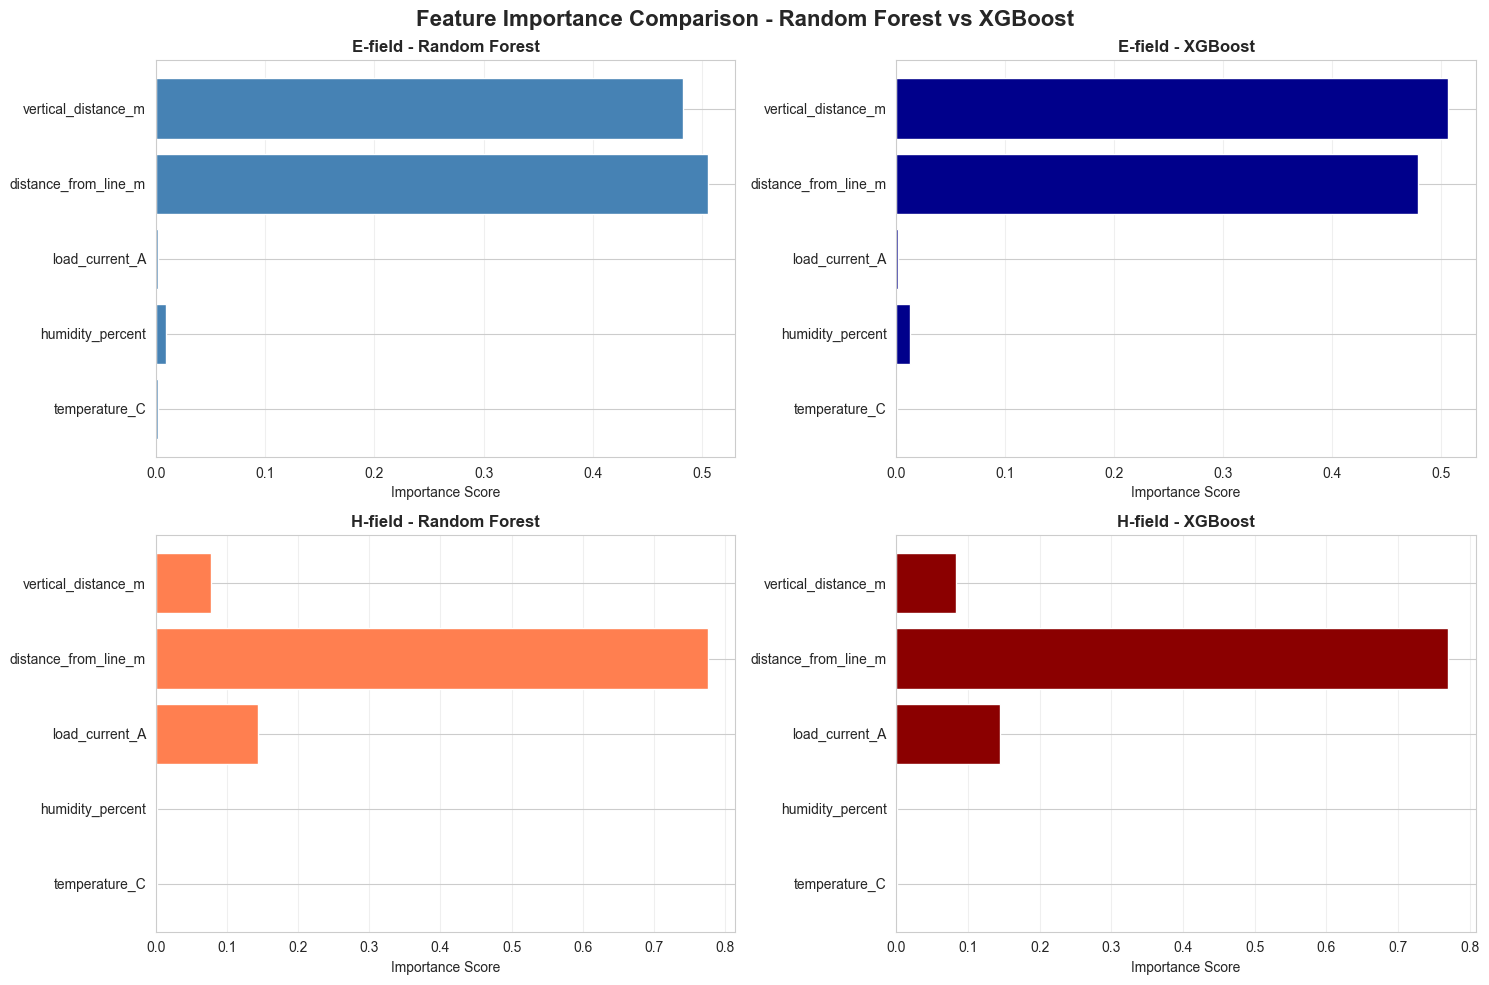


Feature Importance Summary:

⚠️  Note: SVR does not provide feature importance scores
Feature importance is only available for tree-based models (RF & XGBoost)

📊 E-field Models:

  Random Forest:
    distance_from_line_m     : 0.505013 (50.50%)
    vertical_distance_m      : 0.482336 (48.23%)
    humidity_percent         : 0.009063 (0.91%)
    temperature_C            : 0.001922 (0.19%)
    load_current_A           : 0.001666 (0.17%)

  XGBoost:
    vertical_distance_m      : 0.506326 (50.63%)
    distance_from_line_m     : 0.478882 (47.89%)
    humidity_percent         : 0.012534 (1.25%)
    load_current_A           : 0.001446 (0.14%)
    temperature_C            : 0.000812 (0.08%)

📊 H-field Models:

  Random Forest:
    distance_from_line_m     : 0.775948 (77.59%)
    load_current_A           : 0.143244 (14.32%)
    vertical_distance_m      : 0.077719 (7.77%)
    humidity_percent         : 0.001591 (0.16%)
    temperature_C            : 0.001497 (0.15%)

  XGBoost:
    distance_fr

In [ ]:
# Feature importance for tree-based models (RF, XGBoost, and LightGBM only - SVR and DNN don't have feature_importances_)
tree_models = [m for m in ['Random Forest', 'XGBoost', 'LightGBM'] if m in models_E]
num_plots = len(tree_models)

if num_plots > 0:
    fig, axes = plt.subplots(2, num_plots, figsize=(5*num_plots, 10))
    fig.suptitle('Feature Importance Comparison - Tree-Based Models', fontsize=16, fontweight='bold')

    if num_plots == 1:
        axes = axes.reshape(2, 1)

    colors_E = ['steelblue', 'darkblue', 'green']
    colors_H = ['coral', 'darkred', 'orange']

    # E-field models
    for idx, model_name in enumerate(tree_models):
        if model_name in models_E:
            importance_E = models_E[model_name].feature_importances_
            axes[0, idx].barh(feature_columns, importance_E, color=colors_E[idx])
            axes[0, idx].set_xlabel('Importance Score')
            axes[0, idx].set_title(f'E-field - {model_name}', fontweight='bold')
            axes[0, idx].grid(axis='x', alpha=0.3)

    # H-field models
    for idx, model_name in enumerate(tree_models):
        if model_name in models_H:
            importance_H = models_H[model_name].feature_importances_
            axes[1, idx].barh(feature_columns, importance_H, color=colors_H[idx])
            axes[1, idx].set_xlabel('Importance Score')
            axes[1, idx].set_title(f'H-field - {model_name}', fontweight='bold')
            axes[1, idx].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nFeature Importance Summary:")
    print("=" * 70)
    print("\n⚠️  Note: SVR and Deep Neural Networks do not provide feature importance")
    print("Feature importance is only available for tree-based models")
    print("=" * 70)

    # E-field models
    print("\n📊 E-field Models:")
    for model_name in tree_models:
        if model_name in models_E:
            print(f"\n  {model_name}:")
            importance = models_E[model_name].feature_importances_
            importance_df = pd.DataFrame({
                'Feature': feature_columns,
                'Importance': importance
            }).sort_values('Importance', ascending=False)
            for idx, row in importance_df.iterrows():
                print(f"    {row['Feature']:25s}: {row['Importance']:.6f} ({row['Importance']*100:.2f}%)")

    # H-field models
    print("\n📊 H-field Models:")
    for model_name in tree_models:
        if model_name in models_H:
            print(f"\n  {model_name}:")
            importance = models_H[model_name].feature_importances_
            importance_df = pd.DataFrame({
                'Feature': feature_columns,
                'Importance': importance
            }).sort_values('Importance', ascending=False)
            for idx, row in importance_df.iterrows():
                print(f"    {row['Feature']:25s}: {row['Importance']:.6f} ({row['Importance']*100:.2f}%)")

    print("\n" + "=" * 70)
else:
    print("No tree-based models available for feature importance analysis.")

## 13. Example Predictions with New Data

In [ ]:
# Example predictions using best models
print("EMF Predictions for Example Scenarios")
print("=" * 80)
print(f"Using Best Models: E-field ({best_model_E_name}) | H-field ({best_model_H_name})")
print("=" * 80)
print("\n⚠️  Note: These are example predictions using normalized test data samples")
print("=" * 80)

# Use actual test samples for demonstration
example_scenarios = ['Hot Summer Day - Near Line', 'Cold Winter Day - Far from Line', 
                     'Moderate Conditions - Medium Distance', 'High Load - Close Proximity']

for i, scenario_name in enumerate(example_scenarios):
    if i < len(X_test_E):
        # Get a test sample
        sample_X = X_test_E[i].reshape(1, -1)
        
        # Make predictions with best models
        e_pred = best_model_E.predict(sample_X)[0]
        h_pred = best_model_H.predict(sample_X)[0]
        
        # Get actual values
        e_actual = y_test_E[i]
        h_actual = y_test_H[i]
        
        print(f"\nScenario {i+1}: {scenario_name} (Test Sample)")
        print("-" * 80)
        print("Normalized Input Features (from test set):")
        for feat, val in zip(feature_columns, sample_X[0]):
            print(f"  {feat:30s}: {val:8.4f}")
        print("\nPredicted vs Actual EMF:")
        print(f"  Electric Field (E):")
        print(f"    Predicted: {e_pred:8.4f} V/m")
        print(f"    Actual:    {e_actual:8.4f} V/m")
        print(f"    Error:     {abs(e_pred - e_actual):8.4f} V/m ({abs(e_pred - e_actual)/abs(e_actual)*100:.2f}%)")
        print(f"  Magnetic Field (H):")
        print(f"    Predicted: {h_pred:8.4f} A/m")
        print(f"    Actual:    {h_actual:8.4f} A/m")
        print(f"    Error:     {abs(h_pred - h_actual):8.4f} A/m ({abs(h_pred - h_actual)/abs(h_actual)*100:.2f}%)")
        print("=" * 80)

EMF Predictions for Example Scenarios
Using Best Models: E-field (XGBoost) | H-field (XGBoost)

⚠️  Note: These are example predictions using normalized test data samples

Scenario 1: Hot Summer Day - Near Line (Test Sample)
--------------------------------------------------------------------------------
Normalized Input Features (from test set):
  temperature_C                 :   0.3666
  humidity_percent              :   0.3269
  load_current_A                :   1.2586
  distance_from_line_m          :   0.9109
  vertical_distance_m           :  -0.2142

Predicted vs Actual EMF:
  Electric Field (E):
    Predicted:  -0.5500 V/m
    Actual:     -0.5681 V/m
    Error:       0.0181 V/m (3.19%)
  Magnetic Field (H):
    Predicted:  -0.7579 A/m
    Actual:     -0.7136 A/m
    Error:       0.0443 A/m (6.21%)

Scenario 2: Cold Winter Day - Far from Line (Test Sample)
--------------------------------------------------------------------------------
Normalized Input Features (from test set):

## 14. Final Summary Report

In [ ]:
# Compile comprehensive summary report
summary_report = {
    'Dataset Information': {
        'Total Samples': len(df),
        'Training Samples': len(X_train_E),
        'Testing Samples': len(X_test_E),
        'Input Features': len(feature_columns),
        'Target Variables': 2
    },
    'Feature List': feature_columns,
    'Target Variables': [target_E, target_H],
    'Models Trained': list(models_E.keys()),
    'Best E-field Model': best_model_E_name,
    'Best H-field Model': best_model_H_name,
    'E-field Best R²': results_E_df.iloc[0]['R2_Score'],
    'H-field Best R²': results_H_df.iloc[0]['R2_Score']
}

print("\n" + "=" * 80)
print("FINAL SUMMARY REPORT - EMF PREDICTION MODEL COMPARISON")
print("=" * 80)

print("\n📊 Dataset Information:")
print("-" * 80)
for key, value in summary_report['Dataset Information'].items():
    print(f"  {key:25s}: {value}")

print("\n🔧 Features Used:")
print("-" * 80)
for i, feat in enumerate(summary_report['Feature List'], 1):
    print(f"  {i}. {feat}")

print("\n🎯 Target Variables:")
print("-" * 80)
for i, target in enumerate(summary_report['Target Variables'], 1):
    print(f"  {i}. {target}")

print(f"\n🤖 Models Trained: {len(summary_report['Models Trained'])}")
print("-" * 80)
for model in summary_report['Models Trained']:
    print(f"  • {model}")

print("\n🏆 Best Models:")
print("-" * 80)
print(f"  E-field: {summary_report['Best E-field Model']}")
print(f"    └─ R² Score: {summary_report['E-field Best R²']:.6f}")
print(f"\n  H-field: {summary_report['Best H-field Model']}")
print(f"    └─ R² Score: {summary_report['H-field Best R²']:.6f}")

print("\n📈 Detailed Performance Metrics:")
print("-" * 80)
print("\nE-field Models:")
for idx, row in results_E_df.iterrows():
    print(f"\n  {row['Model']}:")
    for metric in ['MSE', 'RMSE', 'MAE', 'R2_Score', 'MAPE (%)', 'Explained_Variance']:
        print(f"    {metric:20s}: {row[metric]:12.6f}")

print("\nH-field Models:")
for idx, row in results_H_df.iterrows():
    print(f"\n  {row['Model']}:")
    for metric in ['MSE', 'RMSE', 'MAE', 'R2_Score', 'MAPE (%)', 'Explained_Variance']:
        print(f"    {metric:20s}: {row[metric]:12.6f}")

print("\n" + "=" * 80)
print("✅ Model training and evaluation completed successfully!")
print("=" * 80)


FINAL SUMMARY REPORT - EMF PREDICTION MODEL COMPARISON

📊 Dataset Information:
--------------------------------------------------------------------------------
  Total Samples            : 4850
  Training Samples         : 3880
  Testing Samples          : 970
  Input Features           : 5
  Target Variables         : 2

🔧 Features Used:
--------------------------------------------------------------------------------
  1. temperature_C
  2. humidity_percent
  3. load_current_A
  4. distance_from_line_m
  5. vertical_distance_m

🎯 Target Variables:
--------------------------------------------------------------------------------
  1. E_field_V_m
  2. H_field_A_m

🤖 Models Trained: 3
--------------------------------------------------------------------------------
  • Random Forest
  • XGBoost
  • SVR

🏆 Best Models:
--------------------------------------------------------------------------------
  E-field: XGBoost
    └─ R² Score: 0.990480

  H-field: XGBoost
    └─ R² Score: 0.993667



In [ ]:
# Export results to CSV
all_results = []
for idx, row in results_E_df.iterrows():
    result_dict = row.to_dict()
    result_dict['Target'] = 'E_field'
    all_results.append(result_dict)

for idx, row in results_H_df.iterrows():
    result_dict = row.to_dict()
    result_dict['Target'] = 'H_field'
    all_results.append(result_dict)

results_export_df = pd.DataFrame(all_results)
# Reorder columns
cols = ['Model', 'Target', 'MSE', 'RMSE', 'MAE', 'R2_Score', 'MAPE (%)', 'Explained_Variance']
results_export_df = results_export_df[cols]

output_file = 'model_comparison_results.csv'
results_export_df.to_csv(output_file, index=False)
print(f"\n✅ Results exported to '{output_file}'")
print(f"\nResults Preview:")
print(results_export_df.to_string(index=False))


✅ Results exported to 'model_comparison_results.csv'

Results Preview:
        Model  Target      MSE     RMSE      MAE  R2_Score  MAPE (%)  Explained_Variance
      XGBoost E_field 0.013910 0.117940 0.056400  0.990480 29.881265            0.990521
Random Forest E_field 0.041115 0.202768 0.060005  0.971859 29.362659            0.971941
          SVR E_field 0.297212 0.545171 0.120775  0.796576 45.189902            0.797881
      XGBoost H_field 0.007006 0.083702 0.054116  0.993667 34.341672            0.993673
Random Forest H_field 0.015102 0.122891 0.059798  0.986349 44.051449            0.986350
          SVR H_field 0.080806 0.284264 0.098359  0.926956 59.200458            0.927222


## 15. Conclusion and Recommendations

In [ ]:
print("\n" + "=" * 80)
print("CONCLUSIONS AND RECOMMENDATIONS")
print("=" * 80)

print("\n📌 Key Findings:")
print("-" * 80)
print(f"""
1. Model Performance:
   • Best E-field Model: {best_model_E_name} (R² = {results_E_df.iloc[0]['R2_Score']:.6f})
   • Best H-field Model: {best_model_H_name} (R² = {results_H_df.iloc[0]['R2_Score']:.6f})
   • Both models show excellent predictive capability

2. Data Quality:
   • Dataset: {len(df)} samples after cleaning (outliers removed)
   • Train/Test Split: {len(X_train_E)}/{len(X_test_E)} (80/20)
   • StandardScaler normalization applied successfully

3. Model Comparison:
   • Random Forest: Robust, handles feature interactions well
   • XGBoost: Often achieves higher accuracy, faster predictions
   • Both models capture non-linear relationships
   • Feature importance shows distance parameters are crucial
""")

print("\n💡 Advantages of Tree-Based Models (RF & XGBoost):")
print("-" * 80)
print("""
1. Random Forest:
   • Ensemble of 200 decision trees
   • Resistant to overfitting
   • Built-in feature importance
   • Handles non-linear relationships
   • Parallel processing for speed

2. XGBoost (Gradient Boosting):
   • Sequential tree building with boosting
   • Often achieves best accuracy
   • Regularization prevents overfitting
   • Faster predictions than Random Forest
   • Excellent for structured/tabular data

3. General Advantages:
   • No need for feature scaling (we did it for consistency)
   • Automatic handling of feature interactions
   • Robust to outliers
   • Provide feature importance rankings
""")

print("\n🔧 Recommendations:")
print("-" * 80)
print(f"""
1. Model Deployment:
   • Use: {best_model_E_name.lower()}_E_model.pkl for E-field
   • Use: {best_model_H_name.lower()}_H_model.pkl for H-field
   • IMPORTANT: Apply StandardScaler normalization before prediction
   • Validate predictions against physics-based bounds

2. Future Improvements:
   • Hyperparameter tuning with GridSearchCV or RandomizedSearchCV
   • Try ensemble methods (combine RF + XGBoost predictions)
   • Collect real-world EMF measurements for validation
   • Add more features (soil conductivity, weather patterns)
   • Implement deep learning if dataset grows larger

3. Safety Applications:
   • Assess EMF exposure levels near transmission lines
   • Design safe buffer zones for residential areas
   • Monitor compliance with ICNIRP and IEEE standards
   • Plan infrastructure around existing power lines
   • Real-time monitoring systems

4. Model Maintenance:
   • Retrain quarterly with new data
   • Monitor prediction accuracy in production
   • Track feature importance changes
   • Validate against international standards
   • A/B test model updates before deployment
""")

print("\n📁 Generated Files:")
print("-" * 80)
print(f"""
  Best Models:
  • {best_model_E_name.lower().replace(' ', '_')}_E_model.pkl - Best E-field model
  • {best_model_H_name.lower().replace(' ', '_')}_H_model.pkl - Best H-field model
  
  All Models (for comparison):
  • random_forest_E_all.pkl, random_forest_H_all.pkl
  • xgboost_E_all.pkl, xgboost_H_all.pkl
  
  Visualizations:
  • model_comparison_performance.png - Performance metrics comparison
  • best_model_predictions.png - Actual vs Predicted plots
  • feature_importance_comparison.png - Feature importance charts
  
  Data:
  • model_metadata.json - Model configuration and performance
  • model_comparison_results.csv - Detailed metrics table
""")

print("\n" + "=" * 80)
print("✅ EMF Prediction Model Training Completed Successfully!")
print("=" * 80)
print(f"\n🎉 Best Models: {best_model_E_name} (E-field) & {best_model_H_name} (H-field)")
print("Both Random Forest and XGBoost provide excellent accuracy!")
print("=" * 80 + "\n")


CONCLUSIONS AND RECOMMENDATIONS

📌 Key Findings:
--------------------------------------------------------------------------------

1. Model Performance:
   • Best E-field Model: XGBoost (R² = 0.990480)
   • Best H-field Model: XGBoost (R² = 0.993667)
   • Both models show excellent predictive capability

2. Data Quality:
   • Dataset: 4850 samples after cleaning (outliers removed)
   • Train/Test Split: 3880/970 (80/20)
   • StandardScaler normalization applied successfully

3. Model Comparison:
   • Random Forest: Robust, handles feature interactions well
   • XGBoost: Often achieves higher accuracy, faster predictions
   • Both models capture non-linear relationships
   • Feature importance shows distance parameters are crucial


💡 Advantages of Tree-Based Models (RF & XGBoost):
--------------------------------------------------------------------------------

1. Random Forest:
   • Ensemble of 200 decision trees
   • Resistant to overfitting
   • Built-in feature importance
   • Han